In [8]:
import sys
sys.path.append('../')
from utils.evaluation import *
from utils.net_classification import *
from GA.geneticAlgorithm import TwoLevelGA
from GA.random_search import RandomSearcher

import numpy as np
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

DATASET = 'MRDBI'
PARENT_DIR = '../../../../evolved_data/%s'
dataset_names = ['test_validation3', 'validation', '1level/54_epochs', 
                 '1level_20gen/54_epochs', 'population_opt', 'random_search/54_epochs']

def plot_rectangle(BB, color='r'):
    x0, y0, x1, y1 = BB
    x0, y0 = x0*0.9, y0*0.9
    x1, y1 = x1*1.1, y1*1.1
    plt.plot([x0, x1], [y0, y0], color=color)
    plt.plot([x0, x1], [y1, y1], color=color)
    plt.plot([x0, x0], [y0, y1], color=color)
    plt.plot([x1, x1], [y0, y1], color=color)

In [3]:
# Load data
def get_data(dataset, parent_dir, loader_object):
    
    runs = os.listdir(parent_dir)
    sorted_h, sorted_ph = get_sorted_individuals_from_evolutions(dataset, parent_dir, runs, loader_object)
    table_h, table_ph = get_sorted_tables(sorted_h=sorted_h, sorted_ph=sorted_ph)
    return table_h, table_ph

def combine_data(dataset, parent_dirs, loader_object):
    sorted_h, sorted_ph = [], []
    for parent_dir in parent_dirs:
        runs = os.listdir(parent_dir)
        sorted_h_, sorted_ph_ = get_sorted_individuals_from_evolutions(dataset, parent_dir, runs, loader_object)
        sorted_h += sorted_h_
        sorted_ph += sorted_ph_
    table_h, table_ph = get_sorted_tables(sorted_h=sorted_h, sorted_ph=sorted_ph)
    return table_h, table_ph
        

In [4]:
table_h, table_ph = get_data(DATASET, PARENT_DIR % 'population_opt', TwoLevelGA)

Loading file ../../../../evolved_data/population_opt/5/MRDBI/genetic/0_2020-07-27-05:08/GA_experiment


Using TensorFlow backend.


Loading file ../../../../evolved_data/population_opt/16/MRDBI/genetic/0_2020-07-28-04:21/GA_experiment
Loading file ../../../../evolved_data/population_opt/17/MRDBI/genetic/0_2020-07-29-18:25/GA_experiment
Loading file ../../../../evolved_data/population_opt/0/MRDBI/genetic/0_2020-07-25-04:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/14/MRDBI/genetic/0_2020-07-29-11:14/GA_experiment
Loading file ../../../../evolved_data/population_opt/11/MRDBI/genetic/0_2020-07-30-17:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/9/MRDBI/genetic/0_2020-07-27-13:10/GA_experiment
Loading file ../../../../evolved_data/population_opt/13/MRDBI/genetic/0_2020-07-27-19:57/GA_experiment
Loading file ../../../../evolved_data/population_opt/7/MRDBI/genetic/0_2020-07-30-09:20/GA_experiment
Loading file ../../../../evolved_data/population_opt/3/MRDBI/genetic/0_2020-07-30-00:50/GA_experiment
Loading file ../../../../evolved_data/population_opt/1/MRDBI/genetic/0_2020-0

In [5]:
table_h.head()

,id,error,code,connections-joins,joins,final_node_with_join,convs_less_identity,n_convs,n_identities,n_rel_cats,...,dropout_mean,filter_mul_max,dropout_max,filter_mul_min,dropout_min,filter_mul_std,dropout_std,kernel_1,kernel_3,kernel_5
0,0,0.077705,||CNN|F:0.8|K:1|A:relu|D:0.40||woCAT||1||\n||C...,9,2,True,3,4,1,0.5,...,0.2125,1,0.4,0.6,0.05,0.147902,0.124373,1,1,2
1,1,0.079227,||Identity||woCAT||1||\n||CNN|F:0.5|K:3|A:relu...,9,3,True,4,5,1,0.666667,...,0.18,0.6,0.3,0.4,0.05,0.0748331,0.0812404,0,4,1
2,2,0.079688,||Identity||woCAT||1||\n||CNN|F:0.7|K:5|A:relu...,5,2,True,3,4,1,0.5,...,0.1875,0.7,0.25,0.6,0.1,0.0433013,0.0649519,2,0,2
3,3,0.079837,||CNN|F:0.7|K:3|A:elu|D:0.35||woCAT||1||\n||CN...,8,3,True,5,5,0,0,...,0.22,0.9,0.35,0.5,0.15,0.16,0.087178,0,3,2
4,4,0.080003,||CNN|F:1.0|K:5|A:relu|D:0.25||woCAT||1||\n||I...,5,3,True,1,3,2,0.666667,...,0.133333,1,0.25,0.9,0.05,0.0471405,0.0849837,0,1,2


In [6]:
def get_tuples(table_h_, table_ph_):
    p_error = []
    a_error = []
    for i in range(len(table_ph_)):
        code = table_ph_['code'][i]
        error = table_ph_['error'][i]
        p_error.append(error)
        for k in range(len(table_h_)):
            code_k = table_h_['code'][k]
            if code == code_k:
                error = table_h_['error'][k]
                a_error.append(error)
    return p_error, a_error
    
def separate(a_error_, p_error_, fitness_lim_low=0.12, fitness_lim_up=0.75):
    p_error_f, a_error_f = [], []
    p_error_u, a_error_u = [], []
    for a, p in zip(a_error, p_error):
        if p < fitness_lim_low:
            p_error_f.append(p)
            a_error_f.append(a)
        elif p > fitness_lim_up:
            p_error_u.append(p)
            a_error_u.append(a)
    return (p_error_f, a_error_f), (p_error_u, a_error_u)

def show_values(p_error, a_error, p_error_f=None, a_error_f=None, title='', classes=None):
    colors = ['g', 'b', 'y', 'c', 'r']
    color = 'b'
    if classes is not None:
        assert len(classes) == len(p_error)
        color = [colors[c] for c in classes]
    plt.figure(figsize=(15,8))
    if p_error_f is not None:
        plt.subplot(1,2,1)
    plt.scatter(a_error, p_error, color=color, label='Pearson coef: %0.2f\np-value: %0.2f' % pearsonr(a_error, p_error))
    plt.xlabel('First Level Fitness')
    plt.ylabel('Second Level Fitness')
    plt.legend(loc = 'upper right')
    plt.title(title)
    if p_error_f is not None:
        plot_rectangle((np.min(a_error_f), np.min(p_error_f), np.max(a_error_f), np.max(p_error_f)))
        plt.subplot(1,2,2)
        plt.scatter(a_error_f, p_error_f, label='Pearson coef: %0.2f\np-value: %0.2f' % pearsonr(a_error_f, p_error_f))
        plt.xlabel('First Level Fitness')
        plt.ylabel('Second Level Fitness')
        plt.legend(loc = 'upper right')
        plt.title(title)
    plt.show()

In [7]:
def get_PCA_and_show(X_feats, n_feats=2):
    N, F = X_feats.shape
    variance = []
    x_trans = None
    for k in range(1, F + 1):
        pca = PCA(n_components=k)
        if k == n_feats:
            x_trans = pca.fit_transform(X_feats)
        else:
            pca.fit(X_feats)
        v = np.sum(pca.explained_variance_ratio_)
        variance.append(v)

    plt.plot(np.arange(F)+1, variance)
    plt.xlabel('N° Selected Features')
    plt.ylabel('Explained Variance')
    plt.title('PCA Dimensionality reduction')
    plt.show()
    return pca, x_trans

    

In [7]:
p_error, a_error = get_tuples(table_h, table_ph)
(p_error_f, a_error_f), (p_error_u, a_error_u) = separate(a_error, p_error)

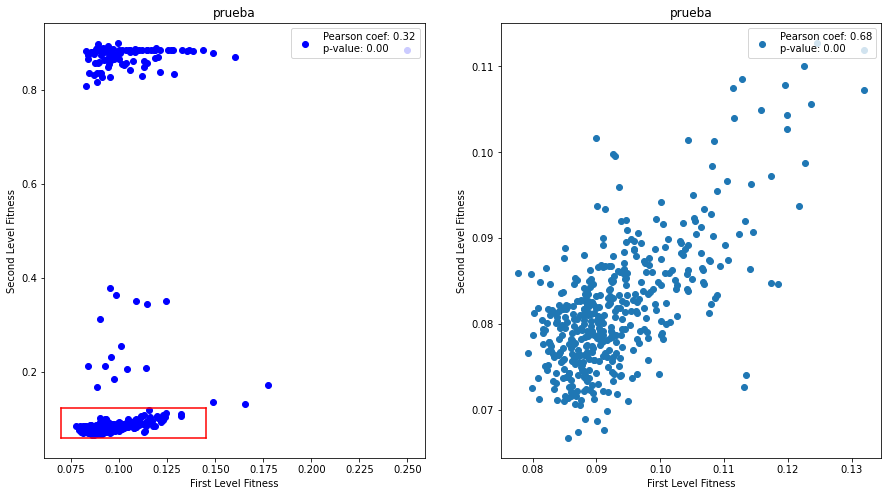

In [8]:
show_values(p_error, a_error, p_error_f, a_error_f, 'prueba')


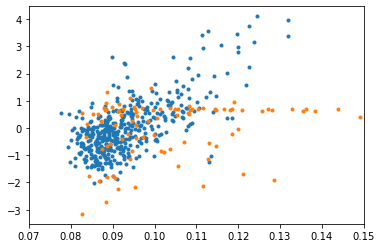

In [9]:
# plot overlapped distributions. Just to discriminate x limits
pup, plow = np.array(p_error_u), np.array(p_error_f)
pup = (pup - np.mean(pup)) / np.std(pup)
plow = (plow - np.mean(plow)) / np.std(plow)
plt.plot(a_error_f, plow, '.')
plt.plot(a_error_u, pup, '.')
plt.xlim([0.07, 0.15])
plt.show()

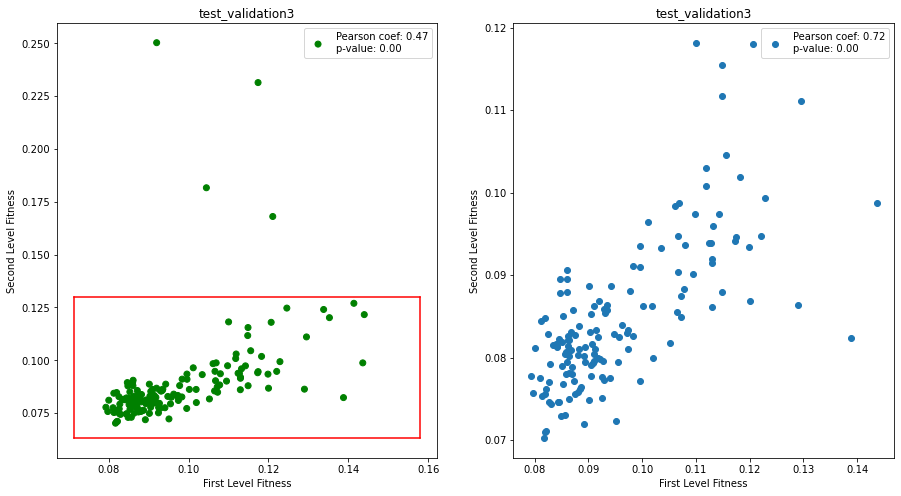

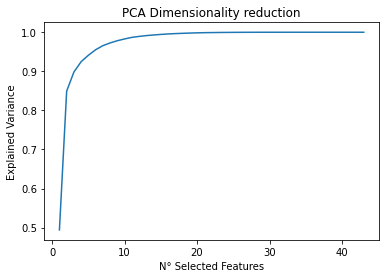

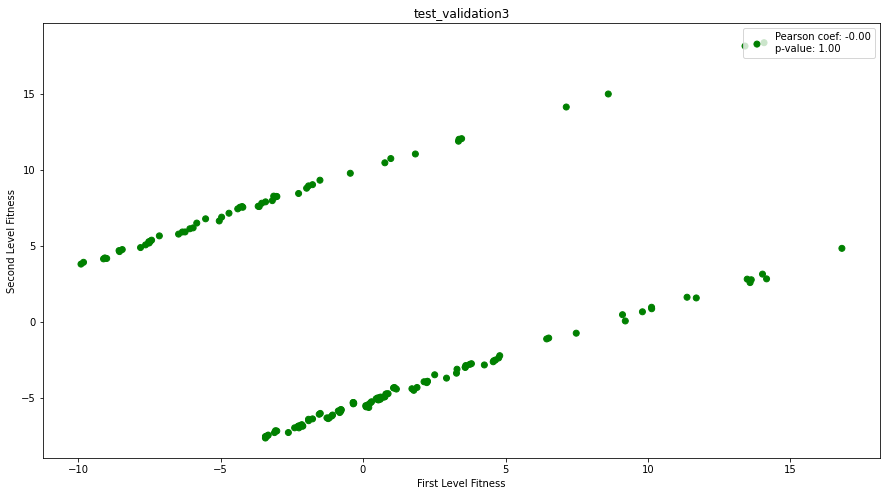

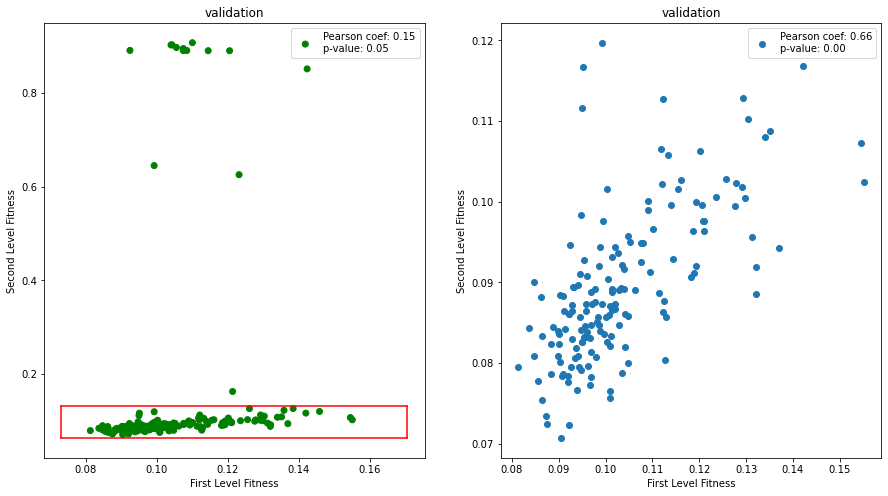

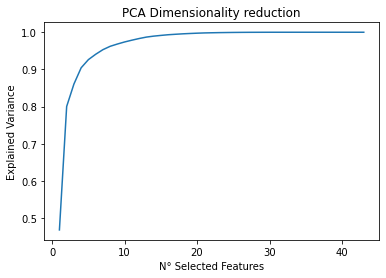

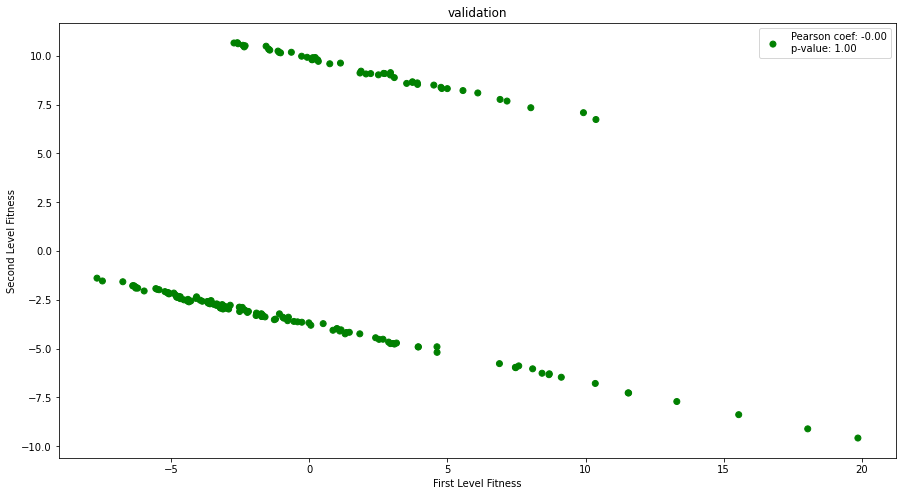

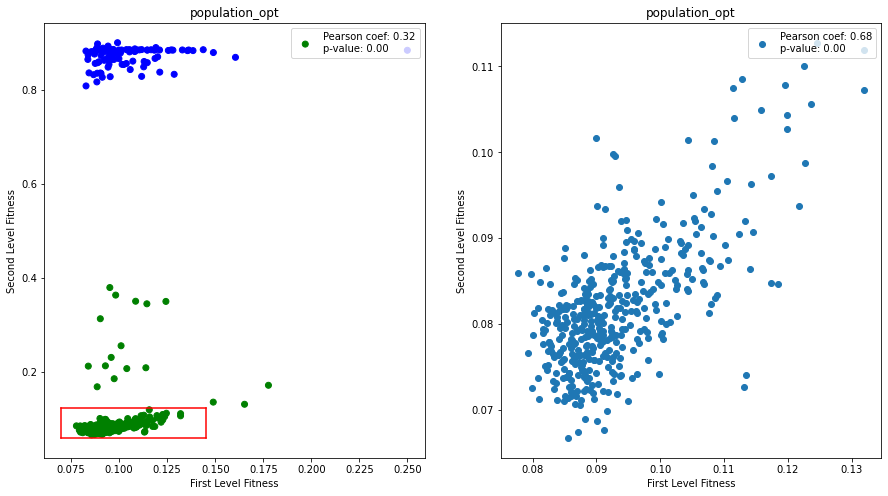

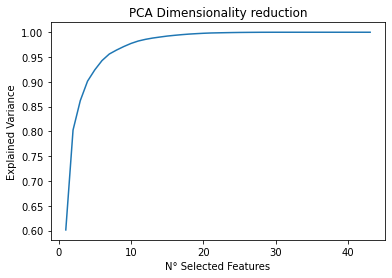

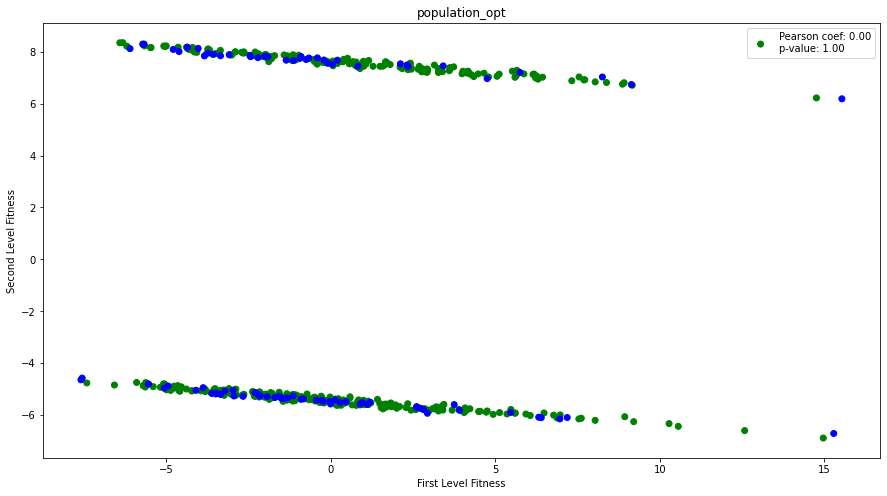

In [118]:
dataset_names_ = ['test_validation3', 'validation', 'population_opt']

X_all = []
for dataset in dataset_names_:
    table_h, table_ph = get_data(DATASET, PARENT_DIR % dataset, TwoLevelGA)
    X_features = get_Xr(table_ph)
    p_error, a_error = get_tuples(table_h, table_ph)
    (p_error_f, a_error_f), (p_error_u, a_error_u) = separate(a_error, p_error)
    
    # cluster with p_fitness and aprox_fitness
    X = np.array([p_error, a_error]).T
    X_all.append(X)
    clust = OPTICS(min_samples=35, xi=.05, min_cluster_size=.05)
    # Run the fit
    clust.fit(X)
    show_values(p_error, a_error, p_error_f, a_error_f, dataset, classes=clust.labels_)
    
    # PCA proyection
    pca, x_trans = get_PCA_and_show(X_features, n_feats=2)
    show_values(x_trans[:,0], x_trans[:,1], title=dataset, classes=clust.labels_)
    

In [119]:
table_h.head()

,id,error,code,connections-joins,joins,final_node_with_join,convs_less_identity,n_convs,n_identities,n_rel_cats,...,dropout_mean,filter_mul_max,dropout_max,filter_mul_min,dropout_min,filter_mul_std,dropout_std,kernel_1,kernel_3,kernel_5
0,0,0.077705,||CNN|F:0.8|K:1|A:relu|D:0.40||woCAT||1||\n||C...,9,2,True,3,4,1,0.5,...,0.2125,1,0.4,0.6,0.05,0.147902,0.124373,1,1,2
1,1,0.079227,||Identity||woCAT||1||\n||CNN|F:0.5|K:3|A:relu...,9,3,True,4,5,1,0.666667,...,0.18,0.6,0.3,0.4,0.05,0.0748331,0.0812404,0,4,1
2,2,0.079688,||Identity||woCAT||1||\n||CNN|F:0.7|K:5|A:relu...,5,2,True,3,4,1,0.5,...,0.1875,0.7,0.25,0.6,0.1,0.0433013,0.0649519,2,0,2
3,3,0.079837,||CNN|F:0.7|K:3|A:elu|D:0.35||woCAT||1||\n||CN...,8,3,True,5,5,0,0,...,0.22,0.9,0.35,0.5,0.15,0.16,0.087178,0,3,2
4,4,0.080003,||CNN|F:1.0|K:5|A:relu|D:0.25||woCAT||1||\n||I...,5,3,True,1,3,2,0.666667,...,0.133333,1,0.25,0.9,0.05,0.0471405,0.0849837,0,1,2


In [102]:
dataset_names_ = ['test_validation3', 'validation', 'population_opt']

table_h, table_ph = combine_data('MRDBI', [PARENT_DIR % d for d in dataset_names_], TwoLevelGA)
thr_d = {}

In [8]:
len(table_h), len(table_ph)

(5409, 546)

In [44]:
fitness_lim = 0.25

def get_proportion(bads, goods, fitness_lim):
    total = len(bads)
    VP = np.sum(bads > fitness_lim)
    FP = np.sum(bads <= fitness_lim)
    VN = np.sum(goods <= fitness_lim)
    FN = np.sum(goods > fitness_lim)
    FPR = FP / (FP + VN)
    TPR = VP / (VP + FN)
    return FPR, TPR, total / (FP + 1)

def search_thr(table_, column, show=False):
    values = [v for v in table_[column] if v is not None]
    values = list(np.sort(np.unique(values)))
    proportions = []
    FPR = []
    TPR = []
    for v in values:
        lower_group = table_[table_[column] < v]['error']
        upper_group = table_[table_[column] >= v]['error']
        
        good_group = lower_group if np.min(lower_group) < np.min(upper_group) else upper_group
        bad_group = upper_group if np.min(lower_group) < np.min(upper_group) else lower_group
        fpr, tpr, dist = get_proportion(bad_group, good_group, fitness_lim)
        proportions.append(dist)
        FPR.append(fpr)
        TPR.append(tpr)
        
    sorted_ids = np.argsort(proportions)[::-1]
    id1 = sorted_ids[0]
    if len(proportions) > 1:
        id2 = sorted_ids[1]
        for id2_aux in sorted_ids:
            if np.abs(id1  - id2_aux) > 0.25 * len(proportions):
                id2 = id2_aux
                break
    else:
        id2 = sorted_ids[0]

    if show:
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,1)
        plt.plot(values, proportions)
        plt.scatter(values[id1], proportions[id1], label="best th: %0.2f" % values[id1])
        plt.scatter(values[id2], proportions[id2], label="scnd best th: %0.2f" % values[id2])
        plt.title("%s sensitization" % column)
        plt.xlabel(str(column))
        plt.legend()
        plt.ylabel('Proportions of bads that were well filtered')

        plt.subplot(1,2,2)
        plt.plot(FPR, TPR, '.', markersize=7)
        plt.plot([0,1], [0,1] ,'--', color='k')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve')
        plt.show()
    return [values[id1], values[id2]], [proportions[id1], proportions[id2]]


def compare_features(table_, delta=0.06, show=False):
    def convert(x):
        return 1. / (x - delta)
    def invert(x):
        return 1. / x + delta
    def show_dist(table, col):
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(table[col], table['error'], '.')
        plt.title("Error vs %s" % col)
        plt.xlabel(col)
        plt.ylabel('Error')
        
        plt.subplot(1,2,2)
        plt.plot(table[col], convert(table['error']), '.')
        plt.title("1/(Error-%0.2f) vs %s" % (delta, col))
        plt.xlabel(col)
        plt.ylabel('1/Error')
        locs, labels = plt.yticks()
        locs = locs[1::]
        plt.yticks(locs, ["%0.2f" % l for l in invert(locs)])
        plt.show()
        return locs
        
    x_ticks = None
    feats = {}
    thr_d = {}
    for c in table_.columns:
        if c in ['code', 'id', 'error']:
            continue

        
        #thr_d[c] = 1000 if c not in thr_d.keys() else thr_d[c]
        #th = input("(Previous value %0.2f) Threshold: " % thr_d[c])
        #thr_d[c] = float(th) if th != '' else thr_d[c]

        ths, scores = search_thr(table_, c)
        thr_d[c] = ths
        total_filtered = 0
        segments = []
        for k in range(len(ths)):
            if scores[k] < 2:
                continue
            lower_group = table_[table_[c] < thr_d[c][k]]['error']
            upper_group = table_[table_[c] >= thr_d[c][k]]['error']

            good_group = lower_group if np.min(lower_group) < np.min(upper_group) else upper_group
            bad_group = upper_group if np.min(lower_group) < np.min(upper_group) else lower_group

            total = len(good_group) + len(bad_group)
            total_filtered += 100*len(bad_group)/total 
            segments.append('lower' if np.min(lower_group) < np.min(upper_group) else 'upper')
            
        if scores[0] > 2 and total_filtered > 1:
            if show:
                locs = show_dist(table_, c)
                plt.figure(figsize=(10, 5))
            for k in range(len(ths)):
                if scores[k] < 2:
                    continue
                lower_group = table_[table_[c] < thr_d[c][k]]['error']
                upper_group = table_[table_[c] >= thr_d[c][k]]['error']

                good_group = lower_group if segments[k]=='lower' else upper_group
                bad_group = upper_group if segments[k]=='lower' else lower_group

                total = len(good_group) + len(bad_group)
                if show:
                    plt.subplot(1,2,k+1)
                    plt.hist([convert(bad_group), convert(good_group)], label=['bads (%0.2f)' % (100*len(bad_group)/total), 
                                                                               'goods (%0.2f)' % (100*len(good_group)/total)],
                             density=False, bins=20)
                    plt.legend()
                    plt.title('Threshold: %0.2f\nScore: %0.2f' % (thr_d[c][k], scores[k]))
                    plt.xlabel("Error")
                    plt.xticks(locs, ["%0.2f" % l for l in invert(locs)])        
            
                if k == 0:
                    feats[c] = [scores[0] , [segments[0]]]
                else: 
                    feats[c] = [scores[0], [segments[0], segments[1]]]
            
            if show:
                plt.show()
    feats = {k: v for k, v in sorted(feats.items(), key=lambda item: item[1][0], reverse=True)}
    for k,v in feats.items():
        feats[k] = (thr_d[k][0:len(v[1])], v[1])
    return feats, thr_d
        

#compare_features(table_h, 0.05)
table_h, table_ph = get_data(DATASET, PARENT_DIR % 'population_opt', TwoLevelGA)
delta = 0.05
feats, thrs = compare_features(table_h, delta)

Loading file ../../../../evolved_data/population_opt/5/MRDBI/genetic/0_2020-07-27-05:08/GA_experiment
Loading file ../../../../evolved_data/population_opt/16/MRDBI/genetic/0_2020-07-28-04:21/GA_experiment
Loading file ../../../../evolved_data/population_opt/17/MRDBI/genetic/0_2020-07-29-18:25/GA_experiment
Loading file ../../../../evolved_data/population_opt/0/MRDBI/genetic/0_2020-07-25-04:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/14/MRDBI/genetic/0_2020-07-29-11:14/GA_experiment
Loading file ../../../../evolved_data/population_opt/11/MRDBI/genetic/0_2020-07-30-17:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/9/MRDBI/genetic/0_2020-07-27-13:10/GA_experiment
Loading file ../../../../evolved_data/population_opt/13/MRDBI/genetic/0_2020-07-27-19:57/GA_experiment
Loading file ../../../../evolved_data/population_opt/7/MRDBI/genetic/0_2020-07-30-09:20/GA_experiment
Loading file ../../../../evolved_data/population_opt/3/MRDBI/genetic/0_2020-0

In [45]:
  
l1 = ['dropout_std', 'filter_mul_std', 'filter_mul_mean', 'filter_mul_max', 'dropout_max', 'convs_less_identity',
     'final_node_is_conv', 'final_node_conv', 'kernel_5', 'filter_mul_min']
l2 = ['final_node_is_conv', 'dropout_std', 'filter_mul_std', 'convs_less_identity', 'filter_mul_mean', 
      'filter_mul_max', 'filter_mul_min', 'kernel_5']
for key in l1:
    try:
        del feats[key]
    except KeyError:
        pass
    
#order_feats = {k: v for k, v in sorted(feats.items(), key=lambda item: item[1][0], reverse=True)}
for k,v in feats.items():
    print(k,'\t\t', v)

n_convs 		 ([1], ['upper'])
LR 		 ([0.0031, 0.2054], ['upper', 'lower'])
dropout_mean 		 ([0.025, 0.65], ['upper', 'lower'])
dropout_min 		 ([0.65, 0.45], ['lower', 'lower'])
WU 		 ([0.1], ['upper'])
n_identities 		 ([4], ['lower'])
n_layers 		 ([4], ['upper'])


In [47]:
def filter_table(table_orig, order_feats, delta=0.05, show=False):
    table_ = table_orig.copy()
    def convert(x):
            return 1. / (x - delta)
    def invert(x):
        return 1. / x + delta
    order_feats_ = {}
    final_thr = {}
    for c in order_feats.keys():
        x_ticks = None

        if show:
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.plot(table_[c], table_['error'], '.')
            plt.title("Error vs %s" % c)
            plt.xlabel(c)
            plt.ylabel('Error')


            plt.subplot(1,2,2)
            plt.plot(table_[c], convert(table_['error']), '.')
            plt.title("1/(Error-%0.2f) vs %s" % (delta, c))
            plt.xlabel(c)
            plt.ylabel('1/Error')
            locs, labels = plt.yticks()
            locs = locs[1::]
            plt.yticks(locs, ["%0.2f" % l for l in invert(locs)])
            plt.show()
        
        '''
        if thr_d is None:
            #th = input("(Previous value %0.2f) Threshold: " % thr_d[c])
            th, score = search_thr(table_, c)
            if score < 2:
                print(c,"Not filtered")
                continue
            thr_[c] = th
        '''
        ths, segs = order_feats[c]
        bads = []
        orig_size = len(table_)
        for k in range(len(ths)):
            th = ths[k]
            seg = segs[k]
            lower_group = table_[table_[c] < th]
            upper_group = table_[table_[c] >= th]

            good_group = lower_group if seg == 'lower' else upper_group
            bad_group = upper_group if seg == 'lower' else lower_group

            table_ = good_group
            bads.append(bad_group)
            
        bad_group = pd.concat(bads)
        good_group = good_group['error']
        bad_group = bad_group['error']
        if len(bad_group) > 0:
            order_feats_[c] = order_feats[c]
            
        total = len(good_group) + len(bad_group)
        assert total == orig_size
        if show:
            plt.figure(figsize=(10, 5))
            plt.subplot(1,2,1)
            plt.hist([convert(bad_group), convert(good_group)], label=['bads (%0.2f)' % (100*len(bad_group)/total), 
                                                                       'goods (%0.2f)' % (100*len(good_group)/total)],
                     density=True, bins=20)
            plt.legend()
            plt.title('Normalized')
            plt.xlabel("Error")
            plt.xticks(locs, ["%0.2f" % l for l in invert(locs)])

            plt.subplot(1,2,2)
            plt.hist([convert(bad_group), convert(good_group)], label=['bads (%d)' % len(bad_group), 
                                                                       'goods (%d)'%len(good_group)],
                     density=False, bins=20)
            plt.legend()
            plt.title("Not normalized")
            plt.xlabel("Error")
            plt.xticks(locs, ["%0.2f" % l for l in invert(locs)])
            plt.show()
        
    return table_, order_feats_

table_h, table_ph = get_data(DATASET, PARENT_DIR % 'population_opt', TwoLevelGA)
new_table, order_feats_final = filter_table(table_h, feats, delta, show=False)

Loading file ../../../../evolved_data/population_opt/5/MRDBI/genetic/0_2020-07-27-05:08/GA_experiment
Loading file ../../../../evolved_data/population_opt/16/MRDBI/genetic/0_2020-07-28-04:21/GA_experiment
Loading file ../../../../evolved_data/population_opt/17/MRDBI/genetic/0_2020-07-29-18:25/GA_experiment
Loading file ../../../../evolved_data/population_opt/0/MRDBI/genetic/0_2020-07-25-04:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/14/MRDBI/genetic/0_2020-07-29-11:14/GA_experiment
Loading file ../../../../evolved_data/population_opt/11/MRDBI/genetic/0_2020-07-30-17:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/9/MRDBI/genetic/0_2020-07-27-13:10/GA_experiment
Loading file ../../../../evolved_data/population_opt/13/MRDBI/genetic/0_2020-07-27-19:57/GA_experiment
Loading file ../../../../evolved_data/population_opt/7/MRDBI/genetic/0_2020-07-30-09:20/GA_experiment
Loading file ../../../../evolved_data/population_opt/3/MRDBI/genetic/0_2020-0

In [48]:
#order_feats_final = {k: v for k, v in sorted(order_feats_final.items(), key=lambda item: item[1], reverse=True)}
for k,v in order_feats_final.items():
    print(k,'\t\t', v)

n_convs 		 ([1], ['upper'])
LR 		 ([0.0031, 0.2054], ['upper', 'lower'])
dropout_mean 		 ([0.025, 0.65], ['upper', 'lower'])
dropout_min 		 ([0.65, 0.45], ['lower', 'lower'])
WU 		 ([0.1], ['upper'])
n_identities 		 ([4], ['lower'])
n_layers 		 ([4], ['upper'])


Original --> Bads: 1537. Goods: 3872
New      --> Bads: 891. Goods: 3408


/home/daniel/Softwares/Anaconda/anaconda3/envs/genetic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


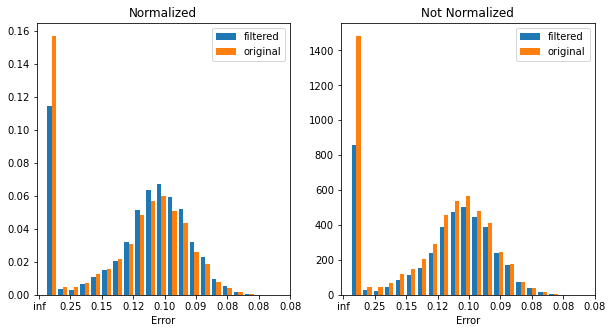

In [49]:
def show_stats(table_h_, new_table_):
    old_total_bads = len(table_h_[table_h_['error'] >= 0.25])
    new_total_bads = len(new_table_[new_table_['error'] >= 0.25])
    old_total_goods = len(table_h_[table_h_['error'] < 0.25])
    new_total_goods = len(new_table_[new_table_['error'] < 0.25])
    print("Original --> Bads: %d. Goods: %d" % (old_total_bads, old_total_goods))
    print("New      --> Bads: %d. Goods: %d" % (new_total_bads, new_total_goods))

def show_hists(new_table_, table_h_, delta):
    def convert(x):
        return 1. / (x - delta)

    def invert(x):
        return 1. / x + delta


    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.hist([convert(new_table_['error']), convert(table_h_['error'])], label=['filtered', 'original'], bins=20,
            density=True)
    plt.legend()
    plt.title('Normalized')
    plt.xlabel('Error')
    locs, labels = plt.xticks()
    locs = locs[1::]
    plt.xticks(locs, ["%0.2f" % l for l in invert(locs)])

    plt.subplot(1,2,2)
    plt.hist([convert(new_table_['error']), convert(table_h_['error'])], label=['filtered', 'original'], bins=20,
            density=False)
    plt.legend()
    plt.title('Not Normalized')
    plt.xlabel('Error')
    plt.xticks(locs, ["%0.2f" % l for l in invert(locs)])
    plt.show()
    
show_stats(table_h, new_table)
show_hists(new_table, table_h, delta)

test_validation3
Loading file ../../../../evolved_data/test_validation3/0/MRDBI/genetic/0_2020-04-18-17:13/GA_experiment
Loading file ../../../../evolved_data/test_validation3/3/MRDBI/genetic/0_2020-04-25-18:29/GA_experiment
Loading file ../../../../evolved_data/test_validation3/1/MRDBI/genetic/0_2020-04-21-08:04/GA_experiment
Loading file ../../../../evolved_data/test_validation3/2/MRDBI/genetic/0_2020-04-23-15:53/GA_experiment
Loading file ../../../../evolved_data/test_validation3/4/MRDBI/genetic/0_2020-04-27-22:08/GA_experiment
Original --> Bads: 148. Goods: 1377
New      --> Bads: 49. Goods: 1118


/home/daniel/Softwares/Anaconda/anaconda3/envs/genetic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


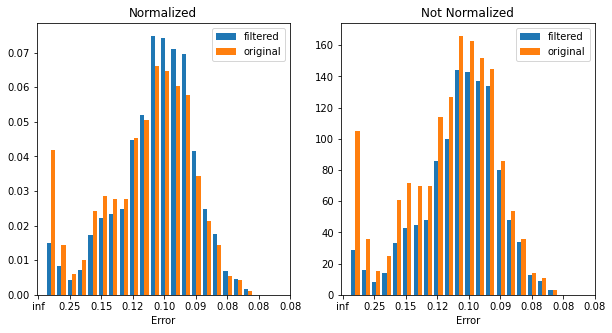



validation
Loading file ../../../../evolved_data/validation/5/MRDBI/genetic/0_2020-03-18-12:10/GA_experiment
Loading file ../../../../evolved_data/validation/0/MRDBI/genetic/0_2020-03-12-12:39/GA_experiment
Loading file ../../../../evolved_data/validation/3/MRDBI/genetic/0_2020-03-16-05:23/GA_experiment
Loading file ../../../../evolved_data/validation/1/MRDBI/genetic/0_2020-03-13-14:56/GA_experiment
Loading file ../../../../evolved_data/validation/2/MRDBI/genetic/0_2020-03-14-22:17/GA_experiment
Loading file ../../../../evolved_data/validation/6/MRDBI/genetic/0_2020-03-19-14:18/GA_experiment
Original --> Bads: 201. Goods: 1568
New      --> Bads: 70. Goods: 1259


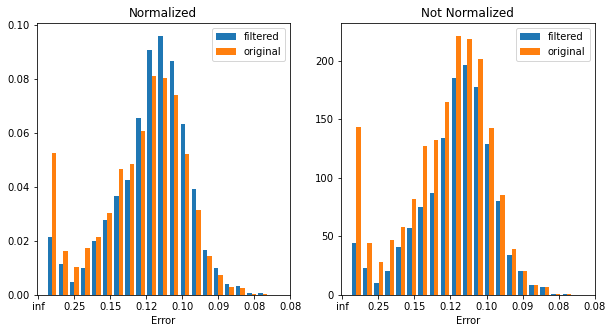



1level/18_epochs
Loading file ../../../../evolved_data/1level/18_epochs/0/MRDBI/genetic/0_2020-06-09-04:26/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level/18_epochs/3/MRDBI/genetic/0_2020-06-11-10:38/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level/18_epochs/1/MRDBI/genetic/0_2020-06-09-19:49/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level/18_epochs/2/MRDBI/genetic/0_2020-06-10-16:46/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level/18_epochs/4/MRDBI/genetic/0_2020-06-12-02:13/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only fir

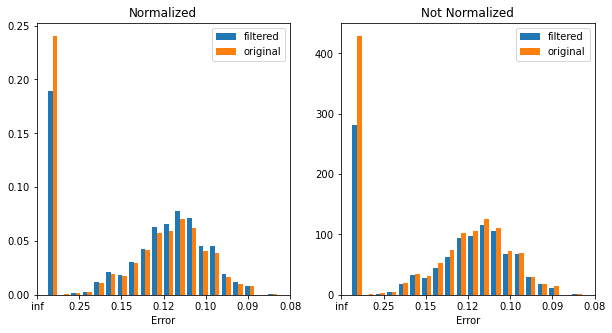



1level_20gen/18_epochs
Loading file ../../../../evolved_data/1level_20gen/18_epochs/0/MRDBI/genetic/0_2020-06-15-21:51/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level_20gen/18_epochs/3/MRDBI/genetic/0_2020-06-19-05:08/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level_20gen/18_epochs/1/MRDBI/genetic/0_2020-06-16-18:27/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level_20gen/18_epochs/2/MRDBI/genetic/0_2020-06-18-02:00/GA_experiment
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Loading file ../../../../evolved_data/1level_20gen/18_epochs/4/MRDBI/genetic/0_2020-06-20-09:34/GA_experiment
'GenerationalGA' object has no attribute 'history

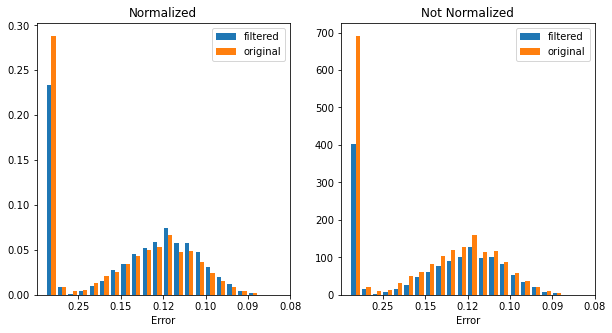



population_opt
Loading file ../../../../evolved_data/population_opt/5/MRDBI/genetic/0_2020-07-27-05:08/GA_experiment
Loading file ../../../../evolved_data/population_opt/16/MRDBI/genetic/0_2020-07-28-04:21/GA_experiment
Loading file ../../../../evolved_data/population_opt/17/MRDBI/genetic/0_2020-07-29-18:25/GA_experiment
Loading file ../../../../evolved_data/population_opt/0/MRDBI/genetic/0_2020-07-25-04:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/14/MRDBI/genetic/0_2020-07-29-11:14/GA_experiment
Loading file ../../../../evolved_data/population_opt/11/MRDBI/genetic/0_2020-07-30-17:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/9/MRDBI/genetic/0_2020-07-27-13:10/GA_experiment
Loading file ../../../../evolved_data/population_opt/13/MRDBI/genetic/0_2020-07-27-19:57/GA_experiment
Loading file ../../../../evolved_data/population_opt/7/MRDBI/genetic/0_2020-07-30-09:20/GA_experiment
Loading file ../../../../evolved_data/population_opt/3/MRDBI

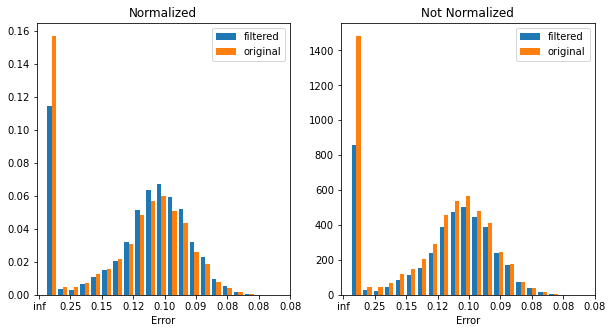



random_search/18_epochs
[Errno 2] No such file or directory: '../../../../evolved_data/random_search/18_epochs/0/MRDBI/genetic'
Trying with folder: ../../../../evolved_data/random_search/18_epochs/0/MRDBI/RS
Loading file ../../../../evolved_data/random_search/18_epochs/0/MRDBI/RS/1_2020-07-07-20:41/GA_experiment
'RandomSearcher' object has no attribute 'history_precision_fitness'
loading only first level
[Errno 2] No such file or directory: '../../../../evolved_data/random_search/18_epochs/3/MRDBI/genetic'
Trying with folder: ../../../../evolved_data/random_search/18_epochs/3/MRDBI/RS
Loading file ../../../../evolved_data/random_search/18_epochs/3/MRDBI/RS/1_2020-07-10-07:01/GA_experiment
'RandomSearcher' object has no attribute 'history_precision_fitness'
loading only first level
[Errno 2] No such file or directory: '../../../../evolved_data/random_search/18_epochs/1/MRDBI/genetic'
Trying with folder: ../../../../evolved_data/random_search/18_epochs/1/MRDBI/RS
Loading file ../../../

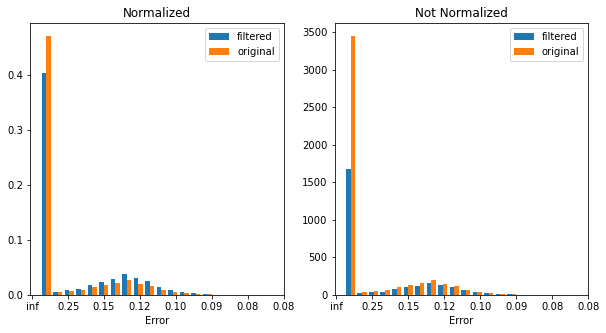



Loading file ../../../../evolved_data/population_opt/5/MRDBI/genetic/0_2020-07-27-05:08/GA_experiment
Loading file ../../../../evolved_data/population_opt/16/MRDBI/genetic/0_2020-07-28-04:21/GA_experiment
Loading file ../../../../evolved_data/population_opt/17/MRDBI/genetic/0_2020-07-29-18:25/GA_experiment
Loading file ../../../../evolved_data/population_opt/0/MRDBI/genetic/0_2020-07-25-04:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/14/MRDBI/genetic/0_2020-07-29-11:14/GA_experiment
Loading file ../../../../evolved_data/population_opt/11/MRDBI/genetic/0_2020-07-30-17:11/GA_experiment
Loading file ../../../../evolved_data/population_opt/9/MRDBI/genetic/0_2020-07-27-13:10/GA_experiment
Loading file ../../../../evolved_data/population_opt/13/MRDBI/genetic/0_2020-07-27-19:57/GA_experiment
Loading file ../../../../evolved_data/population_opt/7/MRDBI/genetic/0_2020-07-30-09:20/GA_experiment
Loading file ../../../../evolved_data/population_opt/3/MRDBI/genetic/0_2020

In [42]:
dataset_names_ = ['test_validation3', 'validation', 'population_opt']
dataset_names_18 = ['test_validation3', 'validation', '1level/18_epochs', 
                 '1level_20gen/18_epochs', 'population_opt', 'random_search/18_epochs']
for dname in dataset_names_18:
    print(dname)
    table_h, table_ph = get_data(DATASET, PARENT_DIR % dname, TwoLevelGA)
    delta = 0.05
    new_table, _ = filter_table(table_h, order_feats_final, delta)
    show_stats(table_h, new_table)
    show_hists(new_table, table_h, delta)
    print("\n")
table_h, table_ph = get_data(DATASET, PARENT_DIR % 'population_opt', TwoLevelGA)

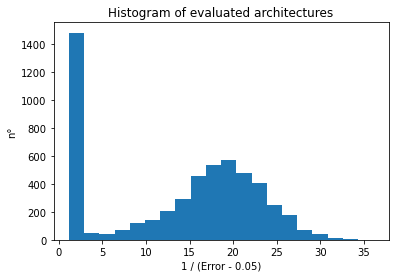

In [208]:
plt.hist(1. / (table_h['error'] - delta) , bins=20)
plt.xlabel('1 / (Error - 0.05)')
plt.ylabel("n°")
plt.title("Histogram of evaluated architectures")
plt.show()

#### Evaluate model filter

In [1]:
import sys
sys.path.append('../')
from utils.filter_models import *

m = ModelFilterV2(None)

Using TensorFlow backend.


n_convs 		 ([1], ['upper'])
LR 		 ([0.0031, 0.2054], ['upper', 'lower'])
dropout_mean 		 ([0.025, 0.65], ['upper', 'lower'])
dropout_min 		 ([0.65, 0.45], ['lower', 'lower'])
WU 		 ([0.1], ['upper'])
n_identities 		 ([4], ['lower'])
n_layers 		 ([4], ['upper'])


test_validation3
Original --> Bads: 148. Goods: 1377
New      --> Bads: 49. Goods: 1118


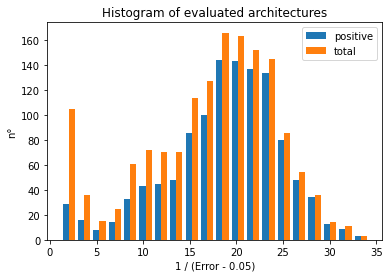

validation
Original --> Bads: 201. Goods: 1568
New      --> Bads: 70. Goods: 1259


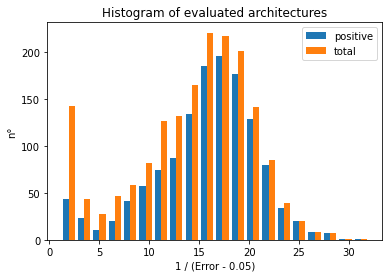

1level/18_epochs
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Original --> Bads: 433. Goods: 867
New      --> Bads: 282. Goods: 800


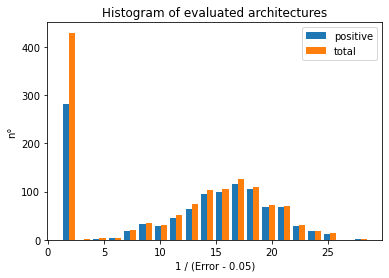

1level_20gen/18_epochs
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
'GenerationalGA' object has no attribute 'history_precision_fitness'
loading only first level
Original --> Bads: 720. Goods: 1194
New      --> Bads: 420. Goods: 955


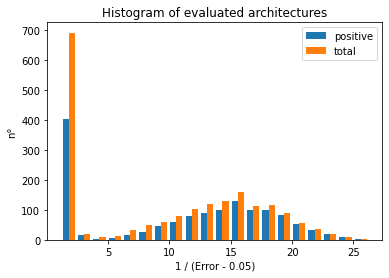

population_opt
Original --> Bads: 1537. Goods: 3872
New      --> Bads: 891. Goods: 3408


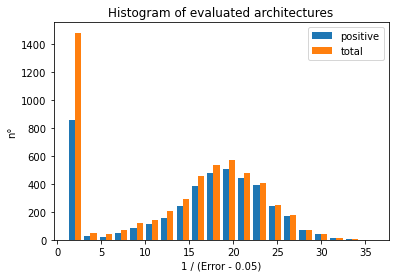

random_search/18_epochs
[Errno 2] No such file or directory: '../../../../evolved_data/random_search/18_epochs/0/MRDBI/genetic'
Trying with folder: ../../../../evolved_data/random_search/18_epochs/0/MRDBI/RS
Loading file ../../../../evolved_data/random_search/18_epochs/0/MRDBI/RS/1_2020-07-07-20:41/GA_experiment
'RandomSearcher' object has no attribute 'history_precision_fitness'
loading only first level
[Errno 2] No such file or directory: '../../../../evolved_data/random_search/18_epochs/3/MRDBI/genetic'
Trying with folder: ../../../../evolved_data/random_search/18_epochs/3/MRDBI/RS
Loading file ../../../../evolved_data/random_search/18_epochs/3/MRDBI/RS/1_2020-07-10-07:01/GA_experiment
'RandomSearcher' object has no attribute 'history_precision_fitness'
loading only first level
[Errno 2] No such file or directory: '../../../../evolved_data/random_search/18_epochs/1/MRDBI/genetic'
Trying with folder: ../../../../evolved_data/random_search/18_epochs/1/MRDBI/RS
Loading file ../../../..

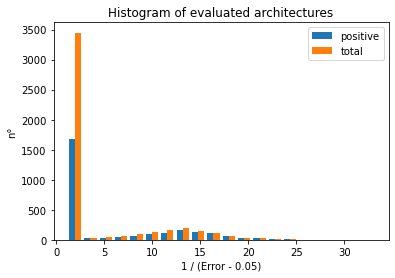

In [6]:
PARENT_DIR = '../../../../evolved_data/%s'

get_all_results(m, PARENT_DIR)